# Learning Gate - Reto | Predicción de Contingencias Ambientales en el Área Metropolitana de la Ciudad de Monterrey

## Data Science Fundamentals - Pyspark with ML


### Installing Missing Libraries

In [ ]:
###
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
!tar xf spark-3.0.0-bin-hadoop3.2.tgz
!pip install -q findspark

### Setting Paths and Importing Libraries

In [ ]:
#All imports
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ['SPARK_HOME'] = '/content/spark-3.0.0-bin-hadoop3.2'
import findspark
findspark.init()
from google.colab import files, drive
drive.mount('/content/drive')
from pyspark import SparkContext, SparkConf,SQLContext
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.stat import Statistics
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import seaborn as sns
sns.set(color_codes=True, font_scale=1.0)
import plotly.express as px
import numpy as np
import pandas as pd
from pyspark.ml.regression import RandomForestRegressor,GBTRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import sum, max, min, avg, count, mean, monotonically_increasing_id

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Starting a Spark Session

In [ ]:
# create sparksession and sparkcontext
sc = SparkContext.getOrCreate(SparkConf().setMaster('local[*]'))
spark = SparkSession \
.builder \
.getOrCreate()
sqlContext = SQLContext(sc)
###
# to retrieve SparkContext version
sc.version

'3.0.0'

### Introduction

Una contingencia ambiental se presenta cuando un contaminante de la atmósfera rebasa los límites establecidos por las normas de calidad del aire vigentes. En diversos países existen contingencias ambientales, el área metropolitana de la ciudad de Monterrey en México es muy frecuente.

Las condiciones del clima como presión, temperatura, humedad relativa, luz solar, velocidad y dirección del viento, etc. afectan la concentración de contaminantes.

Existe la propuesta de implementar un programa de verificación vehicular. Se pretende investigar si la contaminación está ligada al tráfico usando la hora del día cómo representante del mismo.

### Objective

Con el desarrollo del reto integrarás todos los conocimientos adquiridos, cumpliendo los siguientes objetivos:

- Descubrir relaciones entre las variables dependientes e independientes para crear modelos predictivos usando correlación.

- Aplicar modelos predictivos de machine learning y evalúa los resultados.

### Useful Information

En la siguiente tabla se puede observar los datos a manejar, asi como su significado y sus unidades:

In [ ]:
path = '/content/drive/MyDrive/TLG_Data/Abbrevs.csv'
df_info = spark.read.option("delimiter", ";").csv(path, header=True, inferSchema=False)
df_info.toPandas()

,Abrev,Variable,Unidades
0,Date,Fecha en que se tomó la lectura,None
1,Month,Mes del año,None
2,Day,Dia del mes,None
3,DayWeek,Día de la semana en texto,None
4,Weekday,Día de la semana (Domingo=1),None
5,Hour,Hora del dia,None
6,CO,Monóxido de Carbono,Ppm
7,NO,Monóxido de Nitrógeno,Ppb
8,NO2,Dióxido de Nitrógeno,Ppb
9,NOx,Suma de NO y NO2,Ppb


### Loading Data

In [ ]:
path = '/content/drive/MyDrive/TLG_Data/MonterreyPollutionData2.csv'
df_mty = spark.read.csv(path, header=True, inferSchema=True)
df_mty = df_mty.sort(['Month', 'Day', 'Hour'])
df_mty = df_mty.withColumnRenamed("PM2.5", "PM2_5")

#### Schema for the Loaded Data

In [ ]:
df_mty.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- DayWeek: string (nullable = true)
 |-- WeekDay: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- CO: double (nullable = true)
 |-- NO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- NOX: double (nullable = true)
 |-- O3: integer (nullable = true)
 |-- PM10: integer (nullable = true)
 |-- PM2_5: integer (nullable = true)
 |-- PRS: double (nullable = true)
 |-- RAINF: double (nullable = true)
 |-- RH: integer (nullable = true)
 |-- SR: double (nullable = true)
 |-- TOUT: double (nullable = true)
 |-- WSR: double (nullable = true)
 |-- WDV: integer (nullable = true)



#### Loaded Data - Sample

In [ ]:
print('Number of registers', df_mty.count())
df_mty.show(10)

Number of registers 3859
+---------+-----+---+-------+-------+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|     Date|Month|Day|DayWeek|WeekDay|Hour|  CO|  NO| NO2| NOX| O3|PM10|PM2_5|  PRS|RAINF| RH|   SR|TOUT|WSR|WDV|
+---------+-----+---+-------+-------+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|01-ene-15|    1|  1|    jue|      5|   1|2.51|10.2|12.9|23.1| 10| 139|   80|725.4| 0.01| 96|  0.0|3.91|7.2|344|
|01-ene-15|    1|  1|    jue|      5|   2|2.41| 9.2|11.6|20.8|  7|  42|   29|725.0| 0.02| 96|  0.0|3.81|6.3|341|
|01-ene-15|    1|  1|    jue|      5|   3|2.39| 8.1|11.8|19.9|  7|  23|    9|724.4|  0.0| 96|  0.0|3.85|5.2|346|
|01-ene-15|    1|  1|    jue|      5|   5|2.26| 5.3| 8.9|14.2|  7|  23|   14|724.0| 0.01| 96|  0.0|3.79|5.6|336|
|01-ene-15|    1|  1|    jue|      5|   8|2.25| 7.2|10.2|17.4|  5|  15|    8|724.3|  0.0| 96|0.023|3.93|4.8|354|
|01-ene-15|    1|  1|    jue|      5|   9|2.21| 5.8| 8.2|14.0|  7|  16|

## Solving the Spark Challenge

### Removing Irrelevant Features Based on Their Descriptions

The following features will be removed, as explained for each of the presented cases:

- Date: Since all data was obtained for a specific year, seasonality cannot be measured, and therefore, this becomes a redundant feature

- Month: Redundant feature, since no seasonality characteristics can be estimated

- Day: Irrelevant feature since Month is not considered, especially given that we are using the WeekDay feature

- DayWeek: Redundant feature

In [ ]:
df_mty = df_mty.drop(*['Date', 'Month', 'Day', 'DayWeek'])
df_mty.show(10)

+-------+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|WeekDay|Hour|  CO|  NO| NO2| NOX| O3|PM10|PM2_5|  PRS|RAINF| RH|   SR|TOUT|WSR|WDV|
+-------+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|      5|   1|2.51|10.2|12.9|23.1| 10| 139|   80|725.4| 0.01| 96|  0.0|3.91|7.2|344|
|      5|   2|2.41| 9.2|11.6|20.8|  7|  42|   29|725.0| 0.02| 96|  0.0|3.81|6.3|341|
|      5|   3|2.39| 8.1|11.8|19.9|  7|  23|    9|724.4|  0.0| 96|  0.0|3.85|5.2|346|
|      5|   5|2.26| 5.3| 8.9|14.2|  7|  23|   14|724.0| 0.01| 96|  0.0|3.79|5.6|336|
|      5|   8|2.25| 7.2|10.2|17.4|  5|  15|    8|724.3|  0.0| 96|0.023|3.93|4.8|354|
|      5|   9|2.21| 5.8| 8.2|14.0|  7|  16|    6|724.3|  0.0| 96|0.052|4.13|4.2| 15|
|      5|  12|2.38|10.0|10.1|20.1| 10|  22|   17|722.6|  0.0| 96|0.127| 6.6|3.2| 29|
|      5|  13|2.51|11.5|12.3|23.8| 12|  32|   16|721.7|  0.0| 95| 0.15|6.89|4.8|  2|
|      5|  14|2.55|12.0|13.5|25.5| 14|  31|   19|721.0|  0.0| 94|

### Removing Irrelevant Features Based on Their Descriptions

In [ ]:
df_mty.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
WeekDay,3859,4.075926405804613,1.9730397456778934,1,7
Hour,3859,12.037833635656906,6.869487540512547,0,23
CO,3859,1.8006219227779212,0.8720340991225557,0.29,8.56
NO,3859,13.503653796320293,26.856244699079305,2.3,414.3
NO2,3859,17.53928478838196,13.301006799154916,0.4,99.2
NOX,3859,30.973257321216355,36.090498039388436,3.1,436.0
O3,3859,22.658719875615443,16.51056131885926,2,92
PM10,3859,86.04949468774294,49.008874331319646,8,494
PM2_5,3859,27.675822752008294,16.849434279135174,5,123


No features were removed after analyzing their statistics. This is because even when their std is small compared to other features, it is relative since the data needs to be normalized for a fair comparison. Furthermore, a small research was implemented, and as a result, it was validated that all remaining features are related to the forecasting of PM 2.5 and O3 particles.

### Analizing Quartiles Statistics

- Quartiles Characteristics

In [2]:
cols = df_mty.columns[2:]
quartiles = df_mty.approxQuantile(cols,[0.25, 0.5, 0.75], 0)
for i, col in enumerate(cols):
  IQR = quartiles[i][2] - quartiles[i][0]
  lower_fence = quartiles[i][0]-1.5*IQR
  upper_fence = quartiles[i][2]+1.5*IQR
  LowOut = df_mty.filter(df_mty.NO<lower_fence).count()
  UpOut = df_mty.filter(df_mty.NO>upper_fence).count()
  print(i, 'Quartiles for {}:'.format(col), str(quartiles[i]), ', ', 'Lower_Outliers: ', LowOut, '- Upper_Outliers: ', UpOut)

NameError: name 'df_mty' is not defined

- Plotting Boxplots for the Variables of Interests

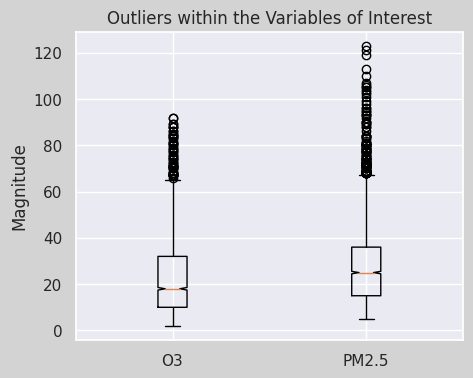

In [ ]:
# Creating arrays containing the variables of interest information
df_mty_o3_temp = df_mty.select("O3")
df_mty_pm25_temp = df_mty.select("PM2_5")
df_mty_o3_temp = df_mty_o3_temp.rdd.map(lambda row : row.O3)
df_mty_pm25_temp = df_mty_pm25_temp.rdd.map(lambda row : row.PM2_5)
arr_mty_o3_temp = df_mty_o3_temp.collect()
arr_mty_pm25_temp = df_mty_pm25_temp.collect()

# Plotting Boxplots
fig, ax = plt.subplots(1,1, figsize=(5,4), facecolor='lightgray')
ax.boxplot([arr_mty_o3_temp, arr_mty_pm25_temp], labels=['O3', 'PM2.5'], notch=True)
ax.set_title('Outliers within the Variables of Interest')
ax.set_ylabel('Magnitude')
plt.show()

- Removing Outliers wihtin the Variables of Interests

In [1]:
# Looping through the Variables of Interests
for i, col in zip([4, 6], ['O3', 'PM2_5']):
  # Estimating the Interquartile Range
  IQR = quartiles[i][2] - quartiles[i][0]
  # Degining the Quartiles Fences
  lower_fence = quartiles[i][0]-1.5*IQR
  upper_fence = quartiles[i][2]+1.5*IQR
  # Displaying reduction in the information size, the removing of outliers
  print(i, col, df_mty.count(), IQR, quartiles[i], lower_fence, upper_fence)
  # Removing Outliers
  df_mty = df_mty.filter((df_mty[col]>=lower_fence) & (df_mty[col]<=upper_fence))
print(df_mty.count())

NameError: name 'quartiles' is not defined

### Features Engineering

#### Removing Irrelevant Information and Estimating Correlation Among Features

In [ ]:
# Removing NaN values
df_mty_dropped = df_mty.na.drop()
# Estimating Pearons Correlation Among Features
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_mty_dropped.columns, outputCol=vector_col)
df_mty_vector = assembler.transform(df_mty_dropped).select(vector_col)
r1 = Correlation.corr(df_mty_vector, vector_col)

#### Plotting the Features Correlation Matrix

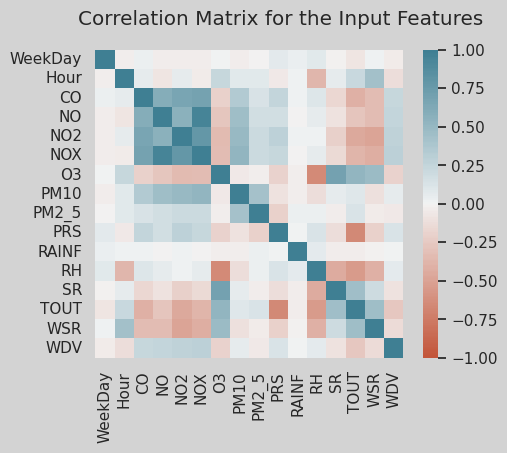

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,4), facecolor='lightgray')
fig.suptitle('Correlation Matrix for the Input Features')
ax = sns.heatmap(r1.collect()[0]["pearson({})".format(vector_col)].values.reshape(len(df_mty.columns),
                 len(df_mty.columns)), xticklabels=df_mty.columns, yticklabels=df_mty.columns,
                 vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200),
                 square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
plt.show()

- Analyzing the Correlation of Features between the Variables of Interest

In [ ]:
df_corr = pd.DataFrame(r1.collect()[0]["pearson({})".format(vector_col)].values.reshape(len(df_mty.columns), len(df_mty.columns)), columns=df_mty.columns, index=df_mty.columns)
df_corr[['O3', 'PM2_5']].transpose()

,WeekDay,Hour,CO,NO,NO2,NOX,O3,PM10,PM2_5,PRS,RAINF,RH,SR,TOUT,WSR,WDV
O3,0.002597,0.241675,-0.205874,-0.278821,-0.33767,-0.332650,1.000000,-0.061473,-0.028865,-0.199972,-0.029271,-0.656093,0.689583,0.518518,0.475125,-0.200398
PM2_5,-0.002806,0.083095,0.140396,0.175017,0.20915,0.207492,-0.028865,0.426536,1.000000,-0.209827,0.027960,0.024929,-0.035409,0.119632,-0.043882,-0.048551


#### Analyzing Relationships Among Features using Dispersion Plots

- Relationships between Features and the O3 Particles Variable

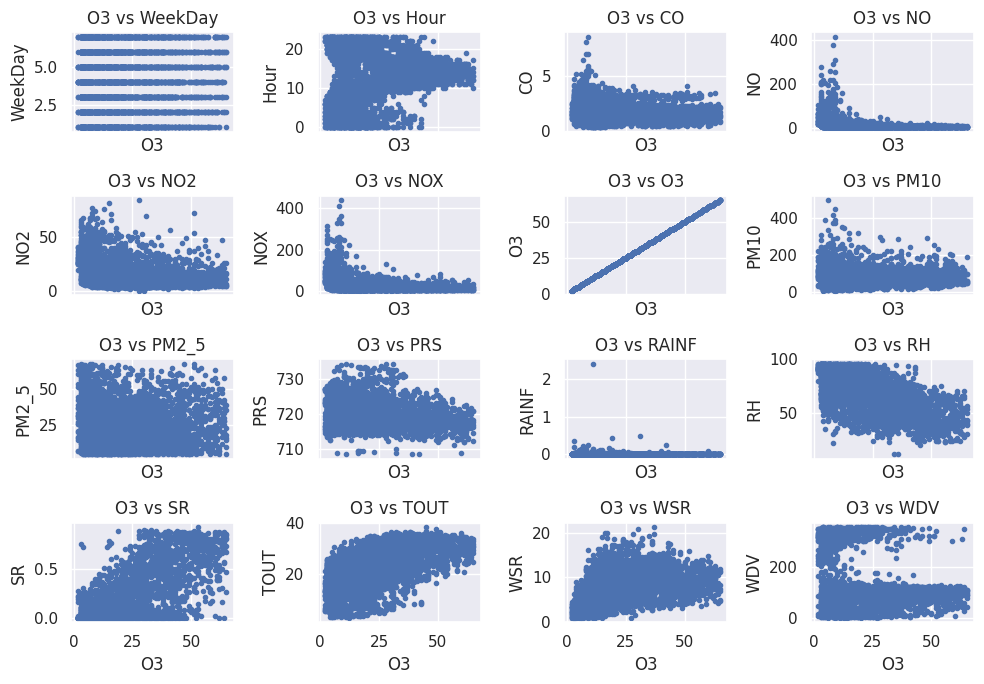

In [ ]:
def DispersionPlots(df, col_name, colorline):

  # Preparing the data for the plotting of the dispersion plots
  cols = df.columns
  df_nona =df.na.drop()
  df_base = df_nona.select(col_name)
  df_base = df_base.rdd.map(lambda row : row[col_name])
  arr_base = df_base.collect()

  # Plotting
  fig, axs = plt.subplots(4,int(np.ceil(len(df_mty.columns[2:])/4)), figsize=(10, 7), facecolor='w', edgecolor='k', sharex=True)
  fig.subplots_adjust(hspace = .5, wspace=.001)
  axs = axs.ravel()
  # Creating plots for each of the features against the selected variable of Interest
  for n in range(len(cols)):
    df_comp = df_nona.select(cols[n])
    df_comp = df_comp.rdd.map(lambda row : row[cols[n]])
    arr_comp = df_comp.collect()
    axs[n].plot(arr_base,arr_comp,colorline)
    axs[n].set_title('{} vs {}'.format(col_name, cols[n]) )
    axs[n].set_ylabel(cols[n])
    axs[n].set_xlabel(col_name)

  fig.tight_layout()

DispersionPlots(df_mty, 'O3', 'b.')

- Relationships between Features and the PM2.5 Particles Variable

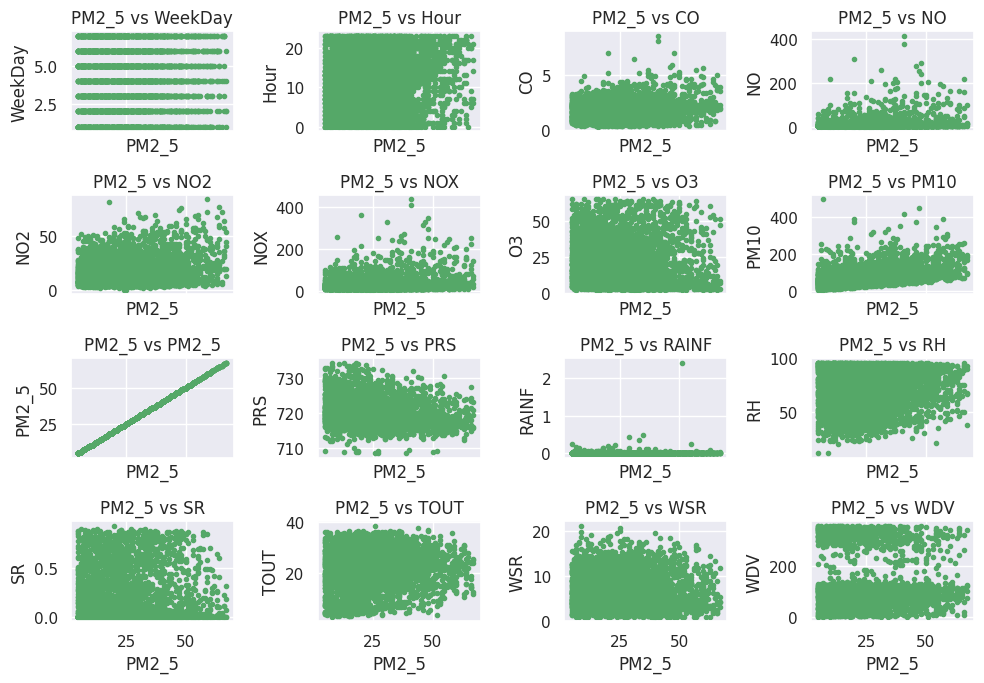

In [ ]:
DispersionPlots(df_mty, 'PM2_5', 'g.')

### Forecasting the generation of O3 and PM2.5 particles

#### Preprocessing the available data

- Filtering uncorrelated variables

In [ ]:
# Creting a correlation matrix to discard variables with weak correlations among the particles to forecast
df_corr = pd.DataFrame(r1.collect()[0]["pearson({})".format(vector_col)].values.reshape(len(df_mty.columns), len(df_mty.columns)), columns=df_mty.columns, index=df_mty.columns)
df_corr[['O3', 'PM2_5']].transpose()

# Filtering viarables with weak correlations
targets = ['O3', 'PM2_5']
cols = df_corr.index[df_corr[df_corr>.1][targets].sum(axis=1)>0].tolist()
features = [col for col in cols if col not in targets]

- Creating needed datasets for the modelling of the data using AI

In [ ]:
# Creating the features vector assembler to store the selected features
assembler = VectorAssembler(inputCols= features, outputCol = 'Attributes')
output = assembler.transform(df_mty)
finalized_data = output.select("Attributes","O3", 'PM2_5')

#Creating the traing and test datasets needed for the training of the AI model
train_data,test_data = finalized_data.randomSplit([0.8,0.2], seed=0)

#### Forecasting the production of O3 particles

- Training Models - Modelling data using AI

In [ ]:
def creating_models_a(col_name, train_data, seed=0):

  # Creating the ML regressors
  lrgr = LinearRegression(featuresCol = 'Attributes', labelCol = col_name)
  rfrgr = RandomForestRegressor(featuresCol = 'Attributes', labelCol = col_name, seed=seed)
  gbtrgr = GBTRegressor(featuresCol = 'Attributes', labelCol = col_name, seed=seed)

  # Training the ML models
  lrgr = lrgr.fit(train_data)
  rfrgr = rfrgr.fit(train_data)
  gbtrgr = gbtrgr.fit(train_data)

  return lrgr, rfrgr, gbtrgr

lrgr, rfrgr, gbtrgr = creating_models_a('O3', train_data.select(['Attributes', 'O3']))

- Evaluating the ML trained models

In [ ]:
def evaluating_models(col_name, lrgr, rfrgr, gbtrgr, test_data):

  # Forecasting Particles
  pred_lr = lrgr.evaluate(test_data)
  pref_rf = rfrgr.transform(test_data)
  pred_gb = gbtrgr.transform(test_data)

  # Evualating the Performance of the trained Models
  # Creating the evaluation methods
  eval_lr = RegressionEvaluator(labelCol=col_name, predictionCol="prediction", metricName="rmse")
  eval_rfr = RegressionEvaluator(labelCol=col_name, predictionCol="prediction", metricName="rmse")
  eval_gbr = RegressionEvaluator(labelCol=col_name, predictionCol="prediction", metricName="rmse")
  # Creating variables to simplify the evaluation
  Evals_res = {}
  predictors = [pred_lr.predictions, pref_rf, pred_gb]
  regressor_names = ['LinearRegressor', 'RandomForest', 'GradientBoosting']
  evals_methods = [eval_lr, eval_rfr, eval_gbr]
  # Evaluation the performance of the trained models
  for predictor, pred_name, eval_reg in zip(predictors, regressor_names, evals_methods):
    tmp_dict = {}
    for metric in ['rmse', 'mse', 'mae', 'r2']:
      tmp_dict[metric] = eval_reg.evaluate(predictor, {eval_reg.metricName: metric})
    Evals_res[pred_name] = tmp_dict

  # Showing Evaluation Results
  display(pd.DataFrame(Evals_res))


evaluating_models('O3', lrgr, rfrgr, gbtrgr, test_data.select(['Attributes', 'O3']))

,LinearRegressor,RandomForest,GradientBoosting
rmse,9.410127,8.062031,6.906035
mse,88.550483,64.996347,47.693320
mae,7.399044,6.084978,5.021190
r2,0.600913,0.707069,0.785051


- Analyzing the Forecasting of Particles

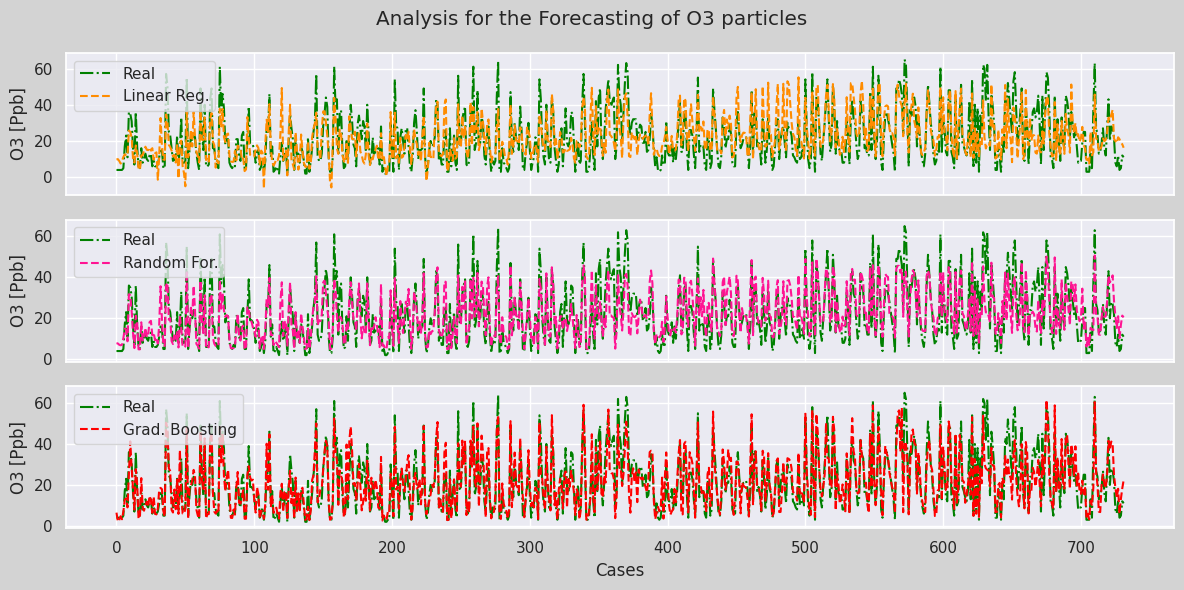

In [ ]:
def plotting_results(col_name, pred_lr, pref_rf, pred_gb):

  # Creating arrays for plotting predictions
  df_real = pred_lr.predictions.rdd.map(lambda row : row[col_name])
  df_pred_lr = pred_lr.predictions.rdd.map(lambda row : row['prediction'])
  df_pred_rf = pref_rf.rdd.map(lambda row : row['prediction'])
  df_pred_gb = pred_gb.rdd.map(lambda row : row['prediction'])

  arr_real = df_real.collect()
  arr_pred_lr = df_pred_lr.collect()
  arr_pred_rf = df_pred_rf.collect()
  arr_pred_gb = df_pred_gb.collect()

  # Plotting predictions for their analysis
  fig, ax = plt.subplots(3,1, figsize=(12,6), facecolor='lightgray', sharex=True)
  plt.suptitle('Analysis for the Forecasting of {} particles'.format(col_name))
  ax1 = plt.subplot(3,1,1)
  ax1.plot(arr_real, color='green', linestyle='-.', label='Real')
  ax1.plot(arr_pred_lr, color= 'darkorange', linestyle='--', label='Linear Reg.')
  ax1.set_ylabel('{} [Ppb]'.format(col_name))
  ax1.legend(loc="upper left")

  ax2 = plt.subplot(3,1,2)
  ax2.plot(arr_real, color='green', linestyle='-.', label='Real')
  ax2.plot(arr_pred_rf, color='deeppink', linestyle='--', label='Random For.')
  ax2.set_ylabel('{} [Ppb]'.format(col_name))
  ax2.legend(loc="upper left")

  ax3 = plt.subplot(3,1,3)
  ax3.plot(arr_real, color='green', linestyle='-.', label='Real')
  ax3.plot(arr_pred_gb, color='red', linestyle='--', label='Grad. Boosting')
  ax3.set_ylabel('{} [Ppb]'.format(col_name))
  ax3.set_xlabel('Cases')
  ax3.legend(loc="upper left")

  fig.tight_layout()


# Forecasting Particles
pred_lr = lrgr.evaluate(test_data.select(['Attributes', 'O3']))
pref_rf = rfrgr.transform(test_data.select(['Attributes', 'O3']))
pred_gb = gbtrgr.transform(test_data.select(['Attributes', 'O3']))

# Using the plotting results function
plotting_results('O3', pred_lr, pref_rf, pred_gb)

### Conclusions

It can be seen in the previous Table and Figure, that it is possible to have a fair prediction of particles O3 based on the provided dataset. Nevertheless, a more robust analysis is needed to increase the accuracy of the predicted values to have more certainty about the presence of O3 particles when using the model.

In [ ]:
O3_predictor = gbtrgr.copy()

#### Forecasting the production of PM2.5 particles

- Training Models - Modelling data using AI

In [ ]:
def creating_models_b(col_name, train_data, seed=0):

  # Creating the ML regressors
  lrgr = LinearRegression(featuresCol = 'Attributes', labelCol = col_name)
  rfrgr = RandomForestRegressor(featuresCol = 'Attributes', labelCol = col_name, maxDepth=7, seed=seed)
  gbtrgr = GBTRegressor(featuresCol = 'Attributes', labelCol = col_name, maxDepth=3, stepSize=.1, seed=seed)

  # Training the ML models
  lrgr = lrgr.fit(train_data)
  rfrgr = rfrgr.fit(train_data)
  gbtrgr = gbtrgr.fit(train_data)

  return lrgr, rfrgr, gbtrgr

lrgr, rfrgr, gbtrgr = creating_models_b('PM2_5', train_data.select(['Attributes', 'PM2_5']))

- Evaluating the ML trained models

In [ ]:
evaluating_models('PM2_5', lrgr, rfrgr, gbtrgr, test_data.select(['Attributes', 'PM2_5']))

,LinearRegressor,RandomForest,GradientBoosting
rmse,12.457806,11.827384,11.643198
mse,155.196931,139.887007,135.564069
mae,9.748390,9.412532,9.275617
r2,0.157060,0.240215,0.263694


- Analyzing the Forecasting of PM2.5 Particles

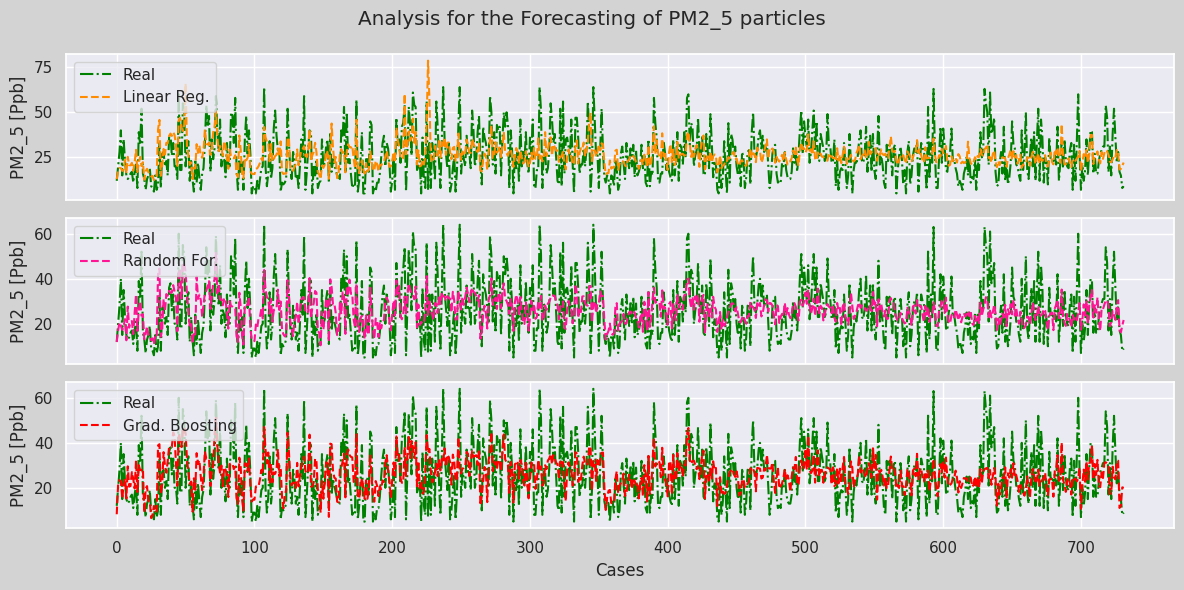

In [ ]:
# Forecasting Particles
pred_lr = lrgr.evaluate(test_data.select(['Attributes', 'PM2_5']))
pref_rf = rfrgr.transform(test_data.select(['Attributes', 'PM2_5']))
pred_gb = gbtrgr.transform(test_data.select(['Attributes', 'PM2_5']))

# Plotting Predictions
plotting_results('PM2_5', pred_lr, pref_rf, pred_gb)

### Conclusions

The performance of the trained model to predict the behaviour of PM2.5 particles is not good enough, as can be seen in the previous Table and Figure. A more complex analysis is needed to determine if it is possible to use the provided data to predict the presence of PM2.5 particles. It is important to determine the quality of the data for its use in this solution, at least for this specific case. It can be observed small to no correlation at all between variables that are well known are related to the presence of the mentioned particles, such as variables related to the weather conditions. This lack of relationship may be associated with the lack of performance when using the trained models to identify underlying patterns within the provided data that are used to predict the presence of PM2.5 particles.  

In [ ]:
PM2_5_predictor = gbtrgr.copy()

## Practicing Learning - Improving Knowledge

### Preparing Data

#### Loading Data

In [ ]:
path = '/content/drive/MyDrive/TLG_Data/MonterreyPollutionData2.csv'
df_mty = spark.read.csv(path, header=True, inferSchema=True)
df_mty = df_mty.sort(['Month', 'Day', 'Hour'])
df_mty = df_mty.withColumnRenamed("PM2.5", "PM2_5")

#### Preprocessing Data

In [ ]:
# Creating Features based on Data Aggregations
for i, col in enumerate(df_mty.columns[6:]):
  df_tmp = df_mty.groupBy('Date').agg(min(col), max(col), mean(col))
  if i == 0:
    df_aggs = df_tmp
  else:
    df_aggs = df_aggs.join(df_tmp, 'Date')

df_aggs.show()

+----------+-------+-------+------------------+-------+-------+------------------+-----------+-----------+------------------+-----------+-----------+------------------+-------+-------+------------------+---------+---------+------------------+----------+----------+------------------+--------+--------+-----------------+----------+----------+--------------------+-------+-------+------------------+-------+-----------+-------------------+---------+---------+------------------+--------+--------+------------------+--------+--------+------------------+
|      Date|min(CO)|max(CO)|           avg(CO)|min(NO)|max(NO)|           avg(NO)|   min(NO2)|   max(NO2)|          avg(NO2)|   min(NOX)|   max(NOX)|          avg(NOX)|min(O3)|max(O3)|           avg(O3)|min(PM10)|max(PM10)|         avg(PM10)|min(PM2_5)|max(PM2_5)|        avg(PM2_5)|min(PRS)|max(PRS)|         avg(PRS)|min(RAINF)|max(RAINF)|          avg(RAINF)|min(RH)|max(RH)|           avg(RH)|min(SR)|    max(SR)|            avg(SR)|min(TOUT)|ma

### Forecasting the generation of O3 and PM2.5 particles

#### Creating needed datasets for the modelling of the data using AI


In [ ]:
# Creating the features vector assembler to store the selected features
features = [col for col in df_aggs.columns[1:] if (('O3' not in col) & ('PM2_5' not in col))]
assembler = VectorAssembler(inputCols= features, outputCol = 'Attributes')
output = assembler.transform(df_aggs)
finalized_data = output.select("Attributes","max(O3)", "max(PM2_5)")

#Creating the traing and test datasets needed for the training of the AI model
train_data,test_data = finalized_data.randomSplit([0.8,0.2], seed=0)

#### Forecasting the production of O3 particles

- Training Models - Modelling data using AI

In [ ]:
lrgr, rfrgr, gbtrgr = creating_models_b('max(O3)', train_data.select(['Attributes', 'max(O3)']))

- Evaluating the ML trained models

In [ ]:
evaluating_models('max(O3)', lrgr, rfrgr, gbtrgr, test_data.select(['Attributes', 'max(O3)']))

,LinearRegressor,RandomForest,GradientBoosting
rmse,11.810044,12.781511,15.676879
mse,139.477138,163.367026,245.764542
mae,9.070269,9.826226,12.311408
r2,0.629869,0.566473,0.347815


- Analyzing the Forecasting of O3 Particles

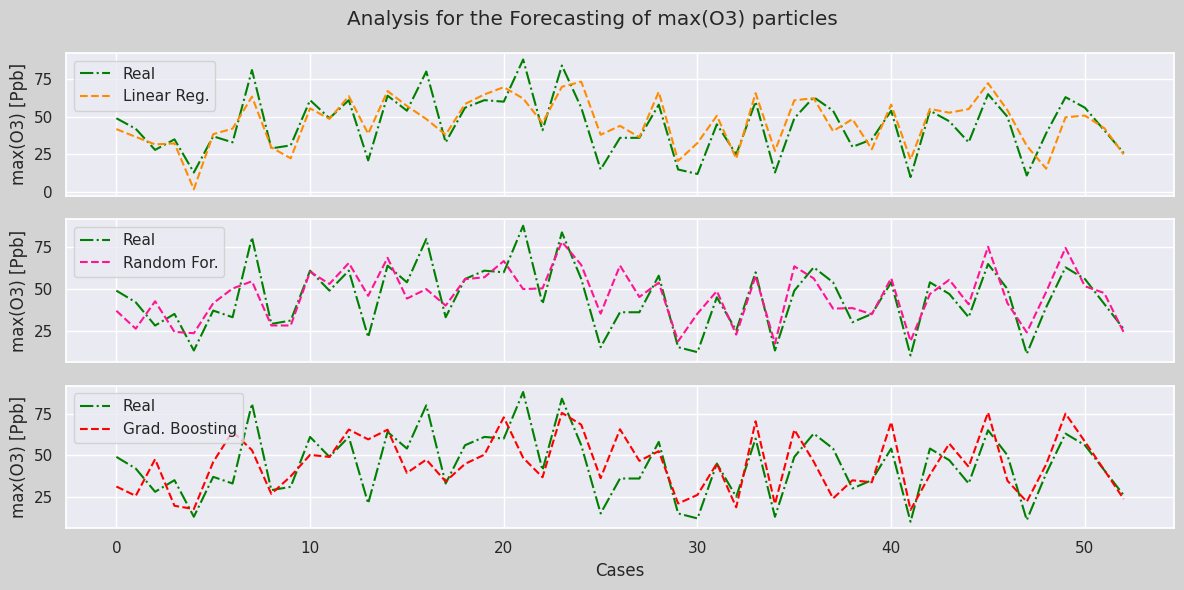

In [ ]:
# Forecasting Particles
pred_lr = lrgr.evaluate(test_data.select(['Attributes', 'max(O3)']))
pref_rf = rfrgr.transform(test_data.select(['Attributes', 'max(O3)']))
pred_gb = gbtrgr.transform(test_data.select(['Attributes', 'max(O3)']))

# Plotting Predictions
plotting_results('max(O3)', pred_lr, pref_rf, pred_gb)

#### Forecasting the production of PM2 particles

- Training Models - Modelling data using AI

In [ ]:
lrgr, rfrgr, gbtrgr = creating_models_b('max(PM2_5)', train_data.select(['Attributes', 'max(PM2_5)']))

- Evaluating the ML trained models

In [ ]:
evaluating_models('max(PM2_5)', lrgr, rfrgr, gbtrgr, test_data.select(['Attributes', 'max(PM2_5)']))

,LinearRegressor,RandomForest,GradientBoosting
rmse,26.156175,20.361725,20.999909
mse,684.145515,414.599841,440.996161
mae,17.548898,14.762894,15.874406
r2,-0.146480,0.305220,0.260986


- Analyzing the Forecasting of O3 Particles

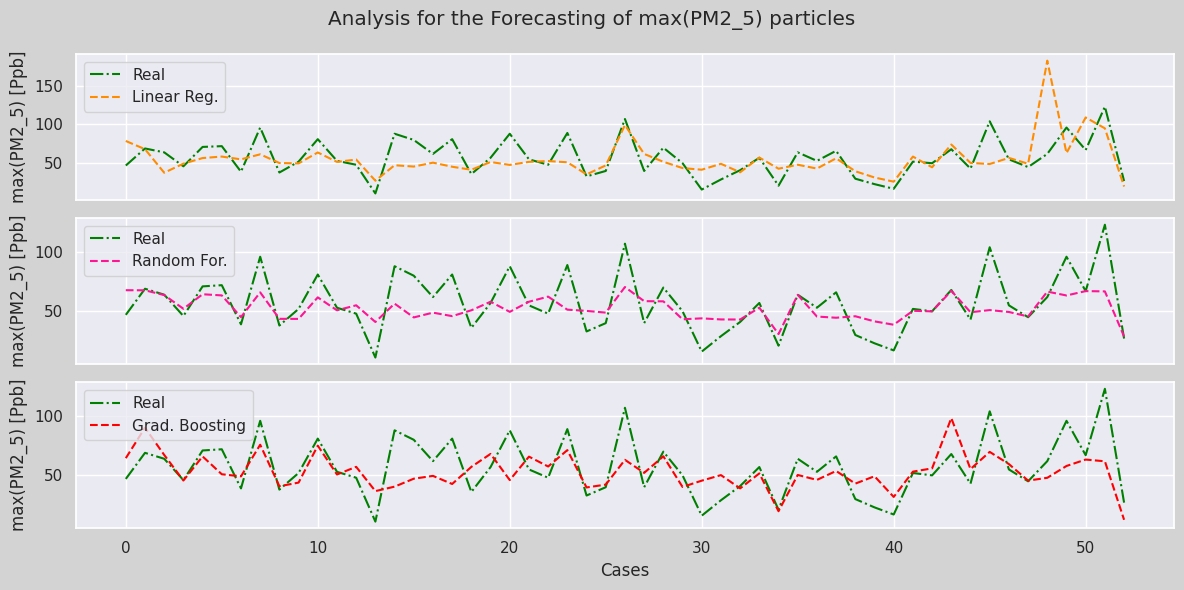

In [ ]:
# Forecasting Particles
pred_lr = lrgr.evaluate(test_data.select(['Attributes', 'max(PM2_5)']))
pref_rf = rfrgr.transform(test_data.select(['Attributes', 'max(PM2_5)']))
pred_gb = gbtrgr.transform(test_data.select(['Attributes', 'max(PM2_5)']))

# Plotting Predictions
plotting_results('max(PM2_5)', pred_lr, pref_rf, pred_gb)

### Conclusion

It can be concluded that we can feature engineering the creation of new characteristics to reduce issues such as the high variability or the lack of relationships between the variables of interest and the available characteristics. However, even by grouping the given characteristics to create new ones, it was not possible to improve the performances of the previously trained models. Nonetheless, this can also be due to the selected hyperparameters on the trained models. Still, due to the lack of performance of the computational resources used for the implementation of this solution, it will require a considerable amount of time to test different sets of hyperparameters to improve the models' performances. Thus, it can be concluded that it is possible the forecast the production of O3 and PM2.5 particles with the data used as inputs, but a more robust analysis is needed to improve the performance of the trained models, and therefore, to increase the accuracy of the forecasted values.

# FIN